In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression

from sklearn import metrics

from sklearn.preprocessing import StandardScaler # for preprocessing the data
from sklearn.ensemble import RandomForestClassifier # Random forest classifier
from sklearn.tree import DecisionTreeClassifier # for Decision Tree classifier
from sklearn.svm import SVC # for SVM classification
from sklearn.linear_model import LogisticRegression
#from sklearn.cross_validation import train_test_split # to split the data
#from sklearn.cross_validation import KFold # For cross vbalidation
from sklearn.model_selection import GridSearchCV # for tunnig hyper parameter it will use all combination of given parameters
from sklearn.model_selection import RandomizedSearchCV # same for tunning hyper parameter but will use random combinations of parameters
from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline



In [2]:
data = pd.read_csv('training.csv')

In [3]:
#data.drop(data[data['Donor_Age']>90].index,inplace=True)
#data.drop(data[data['Donor_Age']<16].index,inplace=True)
data[data['Donor_Age'] < 16]['Donor_Age'] = np.nan
data[data['Donor_Age'] > 90]['Donor_Age'] = np.nan
data[data['Donor_Hemoglobin'] > 20]['Donor_Hemoglobin'] = np.nan
data[data['Donor_Hemoglobin'] < 0]['Donor_Hemoglobin'] = np.nan



In [4]:
age = data[data['Donor_Age'] != np.nan]['Donor_Age']

In [5]:
#data['Test_2'].isna().sum()
test_2 = data[data['Test_2']!= np.nan]['Test_2']


In [6]:
Hemoglobin = data[data['Donor_Hemoglobin'] != np.nan]['Donor_Hemoglobin']



In [7]:
data['Donor_Age'].replace(np.nan,age.median(),inplace=True)
data['Test_2'].replace(np.nan,test_2.median(),inplace=True)
data['Donor_Hemoglobin'].replace(np.nan,Hemoglobin.median(),inplace=True)


In [8]:
#gender = data[data['Gender']!= np.nan]['Gender']
#data['Gender'].replace(np.nan,gender.median(),inplace=True)

In [9]:
data.isna().sum()

Row_ID                      0
Financial_Year              0
Branch_Code                 0
Sequence_1                  0
Sequence_2                  0
Donation_type               0
Donor_Age                   0
Donation_Date               0
Gender                      8
Blood_Group_Code          357
Donor_Weight            24296
Donor_Temperature       24299
Donor_Pulse             24299
Donor_Hemoglobin            0
Donor_Blood_Pressure    24300
Test_1                     57
Test_2                      0
Test_3                      8
Test_4                      8
Y                           0
dtype: int64

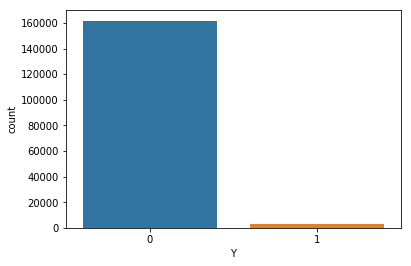

In [10]:
sns.countplot("Y",data=data)

In [11]:
zeros = len(data[data["Y"]==0])
ones = len(data[data["Y"]==1])


In [12]:
zeros

161740

In [13]:
ones

2859

In [14]:
percentage_zero = zeros/(ones+zeros)

In [15]:
percentage_zero*100

98.26305141586522

In [16]:
percentage_one = ones/(ones+zeros)

In [17]:
percentage_one*100

1.736948584134776

In [18]:
affected = data[data["Y"]==1]
not_affected = data[data["Y"]==1]


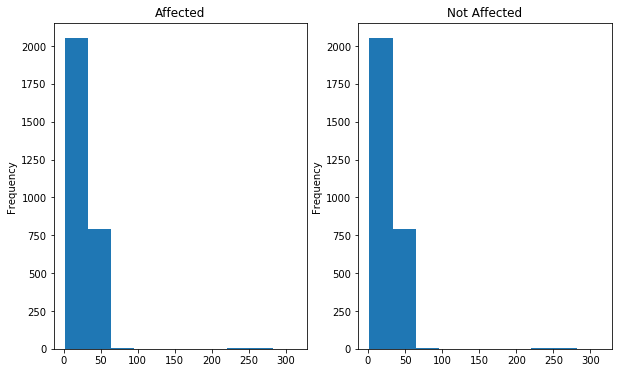

In [19]:
plt.figure(figsize=(10,6))
plt.subplot(121)
affected.Donor_Age.plot.hist(title="Affected")
plt.subplot(122)
not_affected.Donor_Age.plot.hist(title="Not Affected")


In [20]:
zero_index = np.array(data[data.Y ==0].index)
one_index = np.array(data[data.Y ==1].index)
ones

2859

In [21]:
zero_index

array([     0,      1,      2, ..., 164596, 164597, 164598], dtype=int64)

In [22]:
def undersample(one_index,zero_index,times):       
    undersample_zeros_index = np.array(np.random.choice(zero_index,(times*ones),replace=False))
    undersample_data = np.concatenate([one_index,undersample_zeros_index])
    undersample_data = data.loc[undersample_data,:]
    return undersample_data
    
    

In [23]:
sample_data = undersample(one_index,zero_index,1)

In [24]:
sample_data.head()

,Row_ID,Financial_Year,Branch_Code,Sequence_1,Sequence_2,Donation_type,Donor_Age,Donation_Date,Gender,Blood_Group_Code,Donor_Weight,Donor_Temperature,Donor_Pulse,Donor_Hemoglobin,Donor_Blood_Pressure,Test_1,Test_2,Test_3,Test_4,Y
17,8171,14,BRC-1,86152.0,8373,R,32.0,3-Sep-13,M,5.0,77.0,37.0,73.0,143.0,120/8/0,0.141,0.303,N,N,1
48,107863,16,BRC-1,33059.0,30716,M,21.0,22-Apr-16,M,3.0,60.0,37.0,72.0,13.0,120/80,0.094,0.241,N,N,1
219,62073,15,BRC-1,20954.0,19722,R,24.0,5-Jan-15,M,3.0,53.0,37.0,72.0,13.0,120/80,0.373,0.291,N,N,1
247,25968,14,BRC-1,104386.0,26608,R,28.0,16-Jan-14,M,3.0,85.0,37.0,72.0,13.0,120/80,0.203,0.283,N,N,1
325,56037,15,BRC-1,14699.0,13467,R,23.0,28-Oct-14,M,3.0,60.0,37.0,72.0,13.0,120/80,0.283,0.261,N,N,1


In [25]:
def data_prepration(x): # preparing data for training and testing as we are going to use different data 
    #again and again so make a function
    x_features= x.ix[:,x.columns != "Class"]
    x_labels=x.ix[:,x.columns=="Class"]
    x_features_train,x_features_test,x_labels_train,x_labels_test = train_test_split(x_features,x_labels,test_size=0.3)
    print("length of training data")
    print(len(x_features_train))
    print("length of test data")
    print(len(x_features_test))
    return(x_features_train,x_features_test,x_labels_train,x_labels_test)

In [26]:
#

In [27]:
X = sample_data[['Donor_Age','Sequence_2','Sequence_1','Test_2','Donor_Hemoglobin']]
y = sample_data['Y']



In [31]:

from imblearn.over_sampling import SMOTE
## Importing resample
from sklearn.utils import resample

In [32]:
dataset = data.copy()
dataset_features = data[['Donor_Age','Sequence_2','Sequence_1','Test_2','Donor_Hemoglobin']]
dataset_target = data['Y']



In [33]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(dataset_features,
                                                   dataset_target,
                                                   random_state=42)

In [34]:
def get_balanced_train_data(df):
    sm = SMOTE(random_state=42, ratio = 1.0)
    X_train_res, y_train_res = sm.fit_sample(X_train_2, y_train_2)
    ## Returns balanced X_train & y_train
    return (X_train_res, y_train_res)

In [35]:
(X_train_resampled, y_train_resampled) = get_balanced_train_data(data)


In [37]:
svc = SVC()


In [ ]:
svc.fit(X_train_2, y_train_2)


In [ ]:
evaluate_model(svc, X_test_2, y_test_2)


In [ ]:
# logistic

print("hi")


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)  


In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

In [ ]:
y_pred_2 = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

In [ ]:
#SVM

from sklearn.svm import SVC
classifier = SVC(kernel='linear')



In [ ]:
classifier.fit(X_train, y_train)

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:

regressor = RandomForestClassifier(n_estimators=20,random_state=0)
regressor.fit(X_train,y_train)

In [ ]:
y_pred = regressor.predict(X_test)
#y_pred = regressor.predict()

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))  

In [ ]:
correlation = data.corr()
correlation

# Test Data
Remember we need to do cleaning in the test dataset

In [ ]:
data_test = pd.read_csv('test_data.csv')


In [ ]:
data_test[data_test['Donor_Age'] > 90]['Donor_Age'] = np.nan


In [ ]:
data_test[data_test['Donor_Age']<16]['Donor_Age'] = np.nan

In [ ]:
data_test['Donor_Age'].replace(np.nan,age.median(),inplace=True)


In [ ]:
sequence = data[data['Sequence_2'] != np.nan]['Sequence_2']
data_test['Sequence_2'].replace(np.nan,sequence.median(),inplace=True)


In [ ]:

sequence_1 = sequence = data[data['Sequence_1'] != np.nan]['Sequence_1']
data_test['Sequence_1'].replace(np.nan,sequence_1.median(),inplace=True)
data_test['Donor_Hemoglobin'].replace(np.nan,Hemoglobin.median(),inplace=True)


In [ ]:
data_test['Donor_Hemoglobin'].isna().sum()

In [ ]:
data_test['Test_2'].replace(np.nan,test_2.median(),inplace=True)

In [ ]:
y_pred = regressor.predict(data_test[['Sequence_2','Donor_Age','Sequence_1','Test_2','Donor_Hemoglobin']])

In [ ]:
y_pred_2 = logreg.predict(data_test[['Sequence_2','Donor_Age','Sequence_1','Test_2','Donor_Hemoglobin']])

In [ ]:
y_pred_3 = classifier.predict(data_test[['Sequence_2','Donor_Age','Sequence_1','Test_2','Donor_Hemoglobin']])

In [ ]:
submission = pd.DataFrame({'Row_ID':data_test['Row_ID'],'Y':y_pred_3})

In [ ]:
filename = 'Submission.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

In [ ]:
d  = submission[submission['Y']==1]

In [ ]:
len(d)

In [ ]:
e  = submission[submission['Y']==0]

In [ ]:
len(e)